# The Finite Element Mesh


The finite element mesh is a fundamental construct for Underworld models. This notebook will go through different examples of what can be done with Underworld's mesh object. 

#### Overview:

1. Creating, visualising and accessing a mesh object.
2. Modifing a mesh.
3. Loading and saving meshes.

**Keywords:** meshes, mesh geometry, loading data

**References**

1. Moresi, L., Dufour, F., Muhlhaus, H.B., 2002. Mantle convection modeling with viscoelastic/brittle lithosphere: Numerical methodology and plate tectonic modeling. Pure Appl. Geophys. 159 (10), 2335–2356.
2. Moresi, L., Dufour, F., Muhlhaus, H.B., 2003. A Lagrangian integration point finite element method for large deformation modeling of viscoelastic geomaterials. J. Comput. Phys. 184, 476–497.
3. Moresi, L., Quenette, S., Lemiale, V., Meriaux, C., Appelbe, B., Muhlhaus, H.-B., 2007. Computational approaches to studying non-linear dynamics of the crust and mantle. Physics of the Earth and Planetary Interiors 163, 69–82.


In [1]:
import underworld as uw
import glucifer

## Creating, visualising and accessing a mesh object


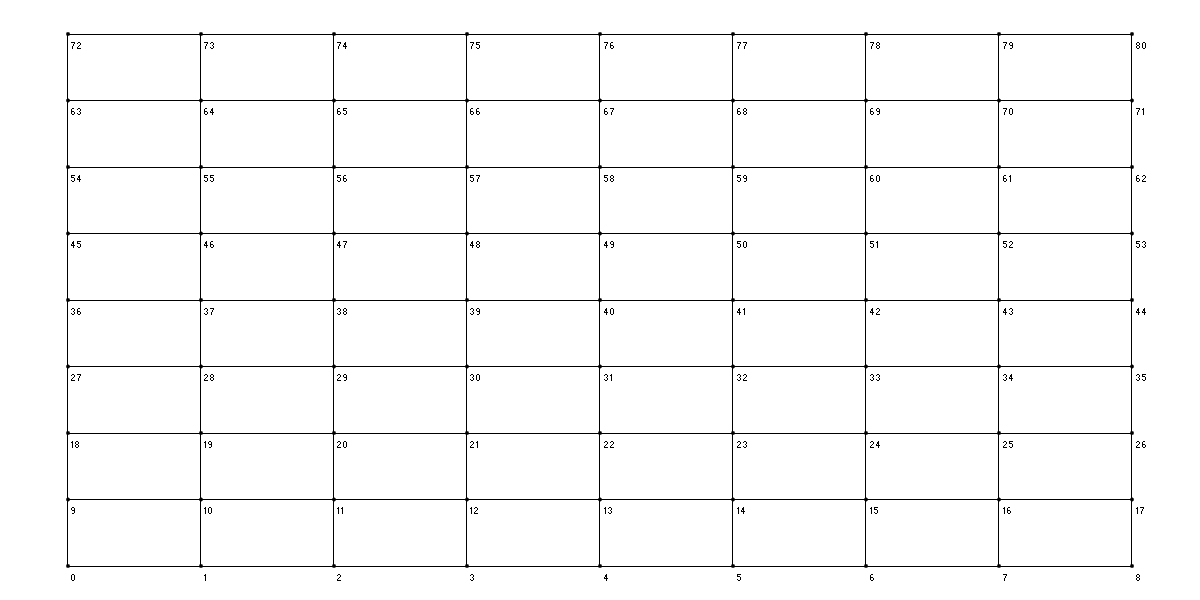

In [2]:
# create an 8x8 rectalinear element mesh 
# range x:[0.0,2.0], y:[0.0,1.0]
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0) )

# visualising the result
figMesh = glucifer.Figure(figsize=(1200,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True) )
figMesh.show()

In [5]:
# The meshes' node geometry data can be directly read via numpy arrays `mesh.data`
node_id = 1
"Coordinate of mesh point {} is {}".format(node_id, mesh.data[node_id])

'Coordinate of mesh point 1 is [ 0.25  0.  ]'

In [6]:
# Sets of node indexes that define boundaries are contained under the `mesh.specialSets` dictionary
mesh.specialSets.keys()

dict_keys(['MaxI_VertexSet', 'MinI_VertexSet', 'MaxJ_VertexSet', 'MinJ_VertexSet', 'AllWalls_VertexSet', 'Empty'])

In [8]:
# The left vertical wall is defined 'MinI_VertexSet' 
# The right vertical wall is defined 'MaxI_VertexSet
# The upper horizontal wall is defined 'MaxJ_VertexSet
# The lower horizontal wall is defined 'MinJ_VertexSet

# Let's have a look at the contents of the left wall set
mesh.specialSets['MinI_VertexSet']

FeMesh_IndexSet([ 0,  9, 18, 27, 36, 45, 54, 63, 72])

#### Element types
The `elementType` input argument for a mesh defines the element shape functions. Shape functions define the polynomial order of finite element mesh.  

Underworld currently supports these element types:
  * Q2: quadratic elements
  * Q1: linear elements
  * dP1c: discontinuous linear elements.
  * dQ0: discontinuous constant elements. (i.e. 1 node in the centre of the element)
 
#### Mixed elements
The mesh object allow for up to 2 element types to be defined for a single mesh. This is initialised by passing a string to the `elementType` argument of the following form:
  * Q2/dpc1
  * Q2/Q1
  * Q1/dQ0


For a definition of finite element naming conventions used in Underworld see [here](https://femtable.org/femtable.pdf)


Let us now create a 2D mesh object with mixed elements (for 3D simply add an extra term in the tuples for the ``elementRes``, ``minCoord`` and ``maxCoord``).


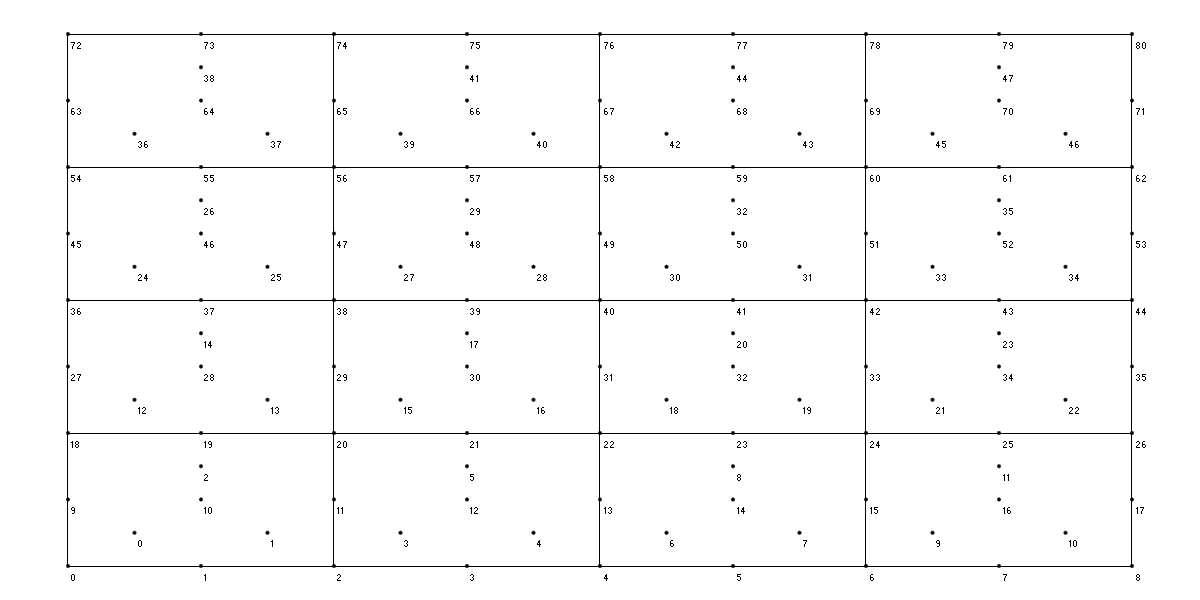

In [15]:
mesh2 = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dpc1"), 
                                  elementRes  = (4, 4), 
                                  minCoord    = (0., 0.), 
                                  maxCoord    = (2., 1.))

figMesh2 = glucifer.Figure(figsize=(1200,600))
figMesh2.append( glucifer.objects.Mesh(mesh2.subMesh, nodeNumbers=True) )
figMesh2.append( glucifer.objects.Mesh(mesh2, nodeNumbers=True, segmentsPerEdge=4) )
figMesh2.show()

In [16]:
# The mesh data for the 2nd element type can be accessed via the `mesh.subMesh`. 
print(' Number of mesh points (Total) = {0:2d}'.format(len(mesh2.data)))
print('      Number of submesh points = {0:2d}'.format(len(mesh2.subMesh.data)))

 Number of mesh points (Total) = 81
      Number of submesh points = 48


## Deforming the mesh

By default the mesh data is read only. The following cell will unlock the mesh and displace a single node of the mesh in the positive x direction.


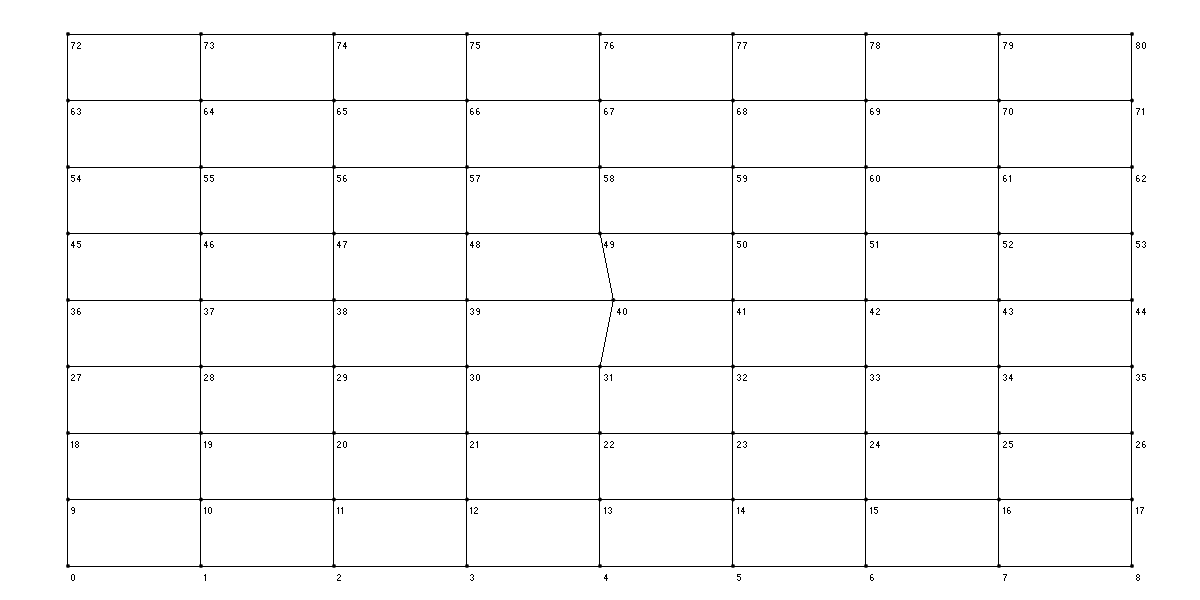

In [17]:
with mesh.deform_mesh():
    mesh.data[40][0] += 0.025
figMesh.show()

Deforming meshes allows us to increase resolution where it is needed most. For example at the top of the simulation domain by redefining the vertical mesh coordinate to be $z := \sqrt{z}$ 


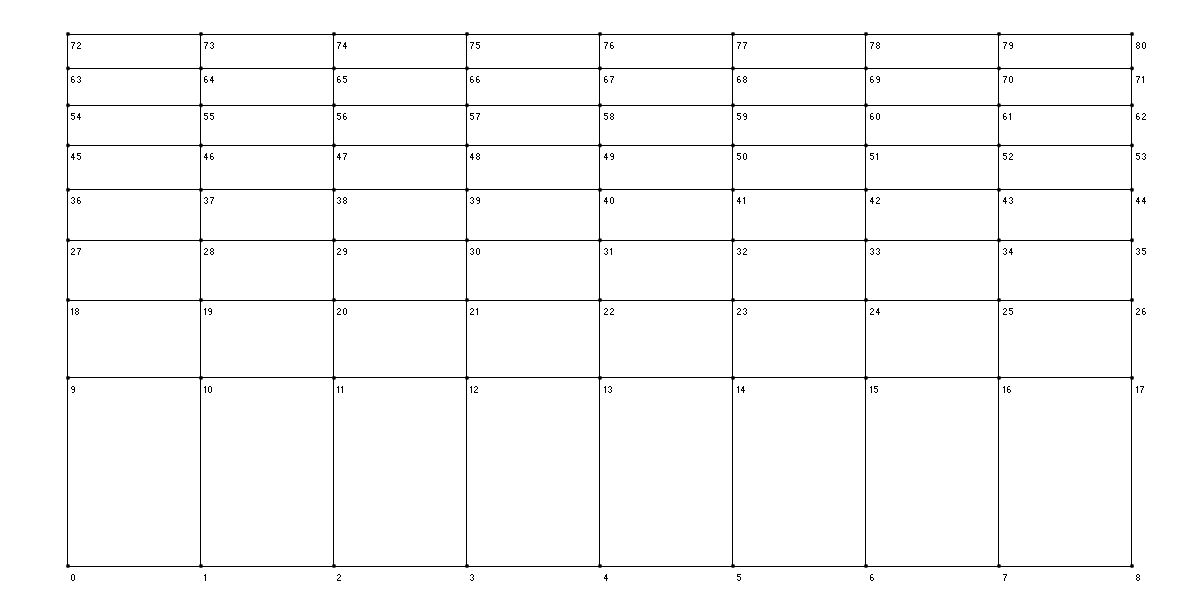

In [18]:
mesh.reset()  # restore the mesh to the original configuration specified by elementType
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
        mesh.data[index][1] = mesh.data[index][1]**0.5
figMesh.show()

## Saving and loading meshes


Mesh coordinate data can be saved in hdf5 format using the ``save`` method attached to the ``mesh`` class. The following line will save the mesh to a file.

In [19]:
mesh.save('deformedMesh.h5')

To check that this has worked we will re-create the mesh, plot and then reload the saved mesh.


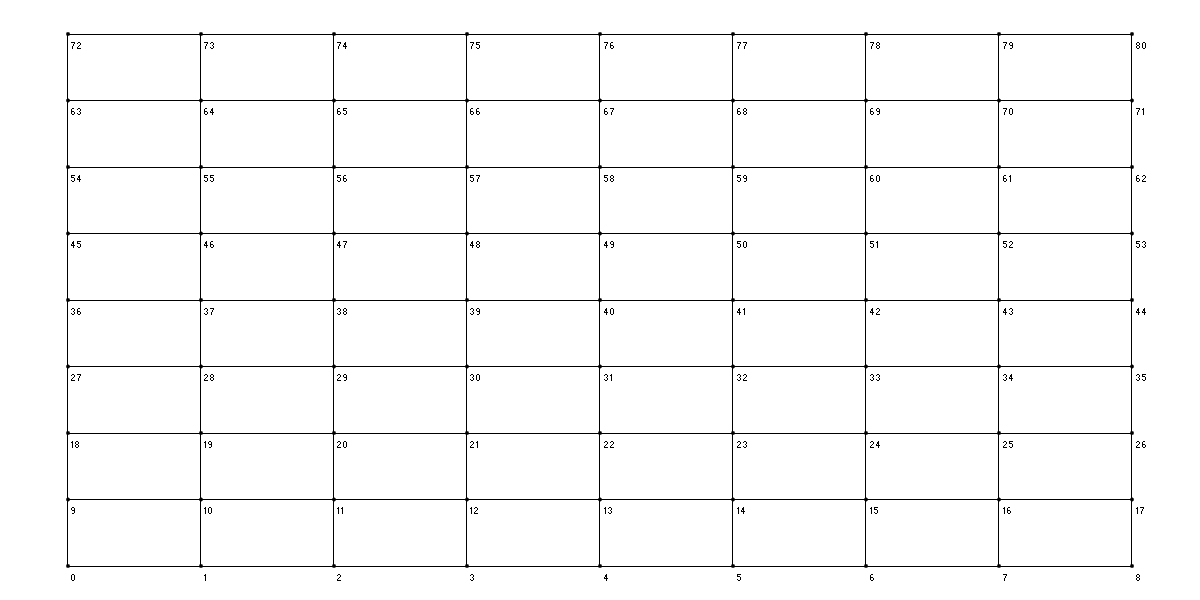

In [20]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (8, 8), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0))
figMesh = glucifer.Figure(figsize=(1200,600))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True) )
figMesh.show()

Now load the mesh and display:


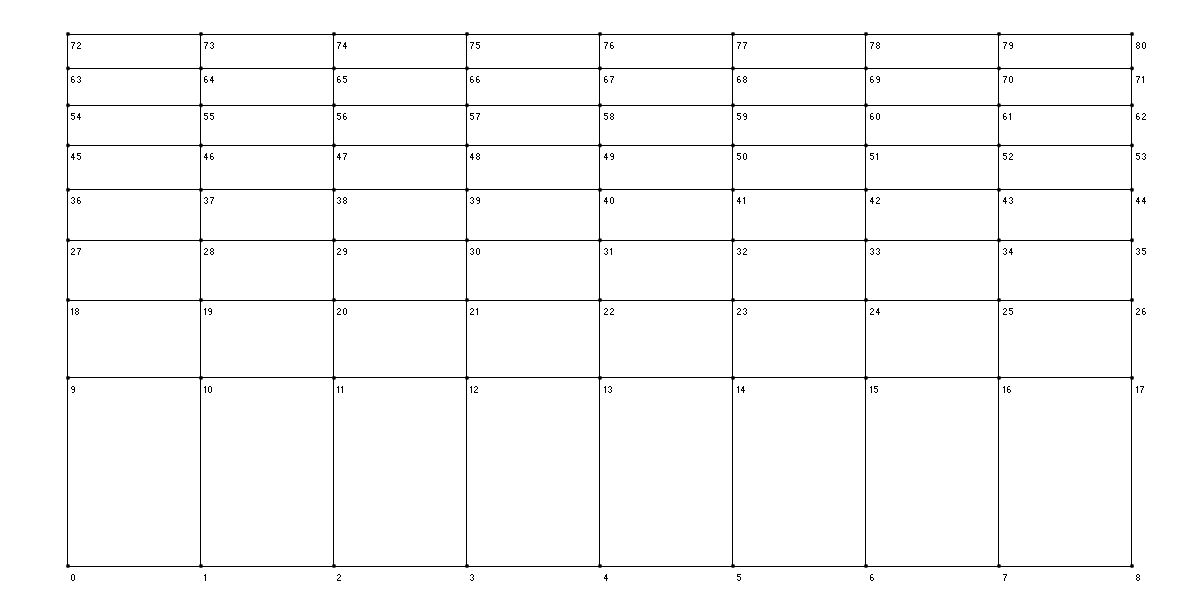

In [21]:
mesh.load('deformedMesh.h5')
figMesh.show()